# Modelo 2 - Credit Fraud Otimização Bayseana com Subamostra de 10%

In [1]:
import numpy as np, pandas as pd, os, gc, re, shap
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Any
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_curve, auc, precision_recall_curve)
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from scipy.sparse import csr_matrix

### Carregar os dados de transações e identidade
### Excluímos as 219 colunas V que foram consideradas redundantes pela análise de correlação

In [2]:
# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [3]:
%%time
# Carregar dataset de transações de treino
X_train = pd.read_csv('ieee-fraud-detection/train_transaction.csv', index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])

# Carregar dataset de identidade de treino
train_id = pd.read_csv('ieee-fraud-detection/train_identity.csv', index_col='TransactionID', dtype=dtypes)

# Combinar transações e identidade no dataset de treino
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)

CPU times: user 7.11 s, sys: 1.5 s, total: 8.61 s
Wall time: 8.61 s


## Subamostra de 10% 
Para identificar o melhor modelo com hiperparâmetros otimizados automaticaticamento pelo nosso algoritmo

In [4]:
%%time
# Amostrar 10% dos dados do dataframe mantendo a proporção da classe isFraud
X_train_sample, _ = train_test_split(X_train, test_size=0.90, stratify=X_train['isFraud'], random_state=42)

# Verificar a distribuição da amostra rotulada
print(X_train_sample['isFraud'].value_counts(normalize=True))

isFraud
0    0.965015
1    0.034985
Name: proportion, dtype: float64
CPU times: user 516 ms, sys: 48.1 ms, total: 564 ms
Wall time: 563 ms


In [5]:
# Separar a variável alvo (isFraud)
y_train = X_train_sample['isFraud'].copy()
del X_train_sample['isFraud']

# Reiniciar os índices para ambos os conjuntos
X_train_sample = X_train_sample.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Verificar o formato dos dados de treino 
print('Formato do dataset de treino:', X_train_sample.shape)

Formato do dataset de treino: (59054, 213)


## O dataset de treinamento "sampleado", rotulado, foi dividido em conjuntos de reino e teste.

In [6]:
# Dividir o dataset em treino e teste (70% treino e 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X_train_sample, y_train, test_size=0.3, random_state=42, stratify=y_train)

# Exibir a nova forma dos dados
print('Novo shape de X_train:', X_train.shape)
print('Novo shape de X_test:', X_test.shape)

Novo shape de X_train: (41337, 213)
Novo shape de X_test: (17717, 213)


## Normalizar as Colunas D
As colunas D representam "deltas de tempo" a partir de algum ponto no passado. Vamos transformar essas colunas em seu ponto no passado, para evitar que elas continuem aumentando com o tempo. A fórmula utilizada será: `D15n = Transaction_Day - D15` e `Transaction_Day = TransactionDT / (24*60*60)`. Após essa transformação, multiplicaremos esse valor por -1.

In [7]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 

In [8]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (str(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'): 
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f] = X_train[f].fillna(-1)
        X_test[f] = X_test[f].fillna(-1)

CPU times: user 154 ms, sys: 0 ns, total: 154 ms
Wall time: 154 ms


## Funções de Codificação
Abaixo estão 5 funções de codificação. (1) `encode_FE` faz a codificação por frequência, onde combina os dados de treino e teste antes de codificar. (2) `encode_LE` faz a codificação de rótulos para variáveis categóricas. (3) `encode_AG` cria variáveis agregadas, como média e desvio padrão agregados. (4) `encode_CB` combina duas colunas. (5) `encode_AG2` cria variáveis agregadas que contam quantos valores únicos de uma característica estão presentes em um grupo. Para mais explicações sobre *feature engineering*, veja a discussão [aqui][1].

**Observação**: Ajustei as funções para evitar os *warnings* de desfragmentação de *DataFrames* no `Pandas`, garantindo que as operações de codificação e agregação sejam realizadas de forma eficiente e sem gerar alertas desnecessários.

[1]: https://www.kaggle.com/c/ieee-fraud-detection/discussion/108575#latest-641841

In [9]:
import pandas as pd
import numpy as np
import gc

# Função ajustada para adicionar novas colunas preservando o índice
def add_new_columns(df, new_cols_dict):
    new_cols_df = pd.DataFrame(new_cols_dict, index=df.index)
    df = pd.concat([df, new_cols_df], axis=1)
    return df

# FUNÇÃO AJUSTADA PARA FREQUENCY ENCODE
def encode_FE(df1, df2, cols):
    df_combined = pd.concat([df1[cols], df2[cols]])
    encodings = {}
    for col in cols:
        vc = df_combined[col].value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        encodings[col] = vc
    new_cols_train = {}
    new_cols_test = {}
    for col in cols:
        nm = col + '_FE'
        new_cols_train[nm] = df1[col].map(encodings[col]).astype('float32')
        new_cols_test[nm] = df2[col].map(encodings[col]).astype('float32')
        print(nm, ', ', end='')
    df1 = add_new_columns(df1, new_cols_train)
    df2 = add_new_columns(df2, new_cols_test)
    return df1, df2

# FUNÇÃO AJUSTADA PARA LABEL ENCODE
def encode_LE(col, train, test, verbose=True):
    df_combined = pd.concat([train[col], test[col]], axis=0)
    df_combined, _ = df_combined.factorize(sort=True)
    nm = col
    dtype = 'int32' if df_combined.max() > 32000 else 'int16'
    train[nm] = df_combined[:len(train)].astype(dtype)
    test[nm] = df_combined[len(train):].astype(dtype)
    if verbose:
        print(nm, ', ', end='')
    gc.collect()

# FUNÇÃO AJUSTADA PARA GROUP AGGREGATION MEAN E STD
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=None, test_df=None, fillna=True, usena=False):
    for main_column in main_columns:
        for col in uids:
            temp_df = pd.concat([train_df[[col, main_column]], test_df[[col, main_column]]])
            if usena:
                temp_df[main_column] = temp_df[main_column].replace(-1, np.nan)
            agg_df = temp_df.groupby([col])[main_column].agg(aggregations)
            agg_df = agg_df.reset_index()
            for agg_type in aggregations:
                new_col_name = f'{main_column}_{col}_{agg_type}'
                agg_series = agg_df.set_index(col)[agg_type]
                train_df[new_col_name] = train_df[col].map(agg_series).astype('float32')
                test_df[new_col_name] = test_df[col].map(agg_series).astype('float32')
                if fillna:
                    train_df[new_col_name] = train_df[new_col_name].fillna(-1)
                    test_df[new_col_name] = test_df[new_col_name].fillna(-1)
                print(f"'{new_col_name}'", ', ', end='')

# FUNÇÃO AJUSTADA PARA COMBINAR FEATURES
def encode_CB(col1, col2, df1, df2):
    nm = col1 + '_' + col2
    new_cols_train = {nm: df1[col1].astype(str) + '_' + df1[col2].astype(str)}
    new_cols_test = {nm: df2[col1].astype(str) + '_' + df2[col2].astype(str)}
    df1 = add_new_columns(df1, new_cols_train)
    df2 = add_new_columns(df2, new_cols_test)
    encode_LE(nm, df1, df2, verbose=False)
    print(nm, ', ', end='')
    return df1, df2

# FUNÇÃO AJUSTADA PARA GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df, test_df):
    for main_column in main_columns:
        for col in uids:
            temp_df = pd.concat([train_df[[col, main_column]], test_df[[col, main_column]]])
            nunique_series = temp_df.groupby(col)[main_column].nunique()
            new_col_name = f'{col}_{main_column}_ct'
            train_df[new_col_name] = train_df[col].map(nunique_series).astype('float32')
            test_df[new_col_name] = test_df[col].map(nunique_series).astype('float32')
            print(new_col_name + ', ', end='')

## Engenharia de *Features*
A equipe vencedora criou novas *features*, escolhendo cada uma delas porque aumentavam a validação local. O procedimento para a criação de *features* utilizado pela equipe foi o seguinte: primeiro, eles pensavam em uma ideia e criavam uma nova *feature*. Em seguida, adicionavam essa *feature* ao modelo e avaliavam se o **AUC** da validação local aumentava ou diminuía. Se o AUC aumentasse, mantinham a *feature*; caso contrário, a descartavam.

In [10]:
%%time
# Defragmentando os DataFrames antes de começar
X_train = X_train.copy()
X_test = X_test.copy()

# Criando a coluna 'cents' e adicionando sem fragmentação
new_cols_train = {}
new_cols_test = {}
new_cols_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
new_cols_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')

X_train = add_new_columns(X_train, new_cols_train)
X_test = add_new_columns(X_test, new_cols_test)

# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
X_train, X_test = encode_FE(X_train, X_test, ['addr1', 'card1', 'card2', 'card3', 'P_emaildomain'])

# COMBINAR COLUNAS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
new_cols_train = {}
new_cols_test = {}
new_cols_train['card1_addr1'] = X_train['card1'].astype(str) + '_' + X_train['addr1'].astype(str)
new_cols_test['card1_addr1'] = X_test['card1'].astype(str) + '_' + X_test['addr1'].astype(str)

new_cols_train['card1_addr1_P_emaildomain'] = new_cols_train['card1_addr1'] + '_' + X_train['P_emaildomain'].astype(str)
new_cols_test['card1_addr1_P_emaildomain'] = new_cols_test['card1_addr1'] + '_' + X_test['P_emaildomain'].astype(str)

X_train = add_new_columns(X_train, new_cols_train)
X_test = add_new_columns(X_test, new_cols_test)

# FREQUENCY ENCODE NOVAMENTE
X_train, X_test = encode_FE(X_train, X_test, ['card1_addr1', 'card1_addr1_P_emaildomain'])

# GROUP AGGREGATE
encode_AG(['TransactionAmt', 'D9', 'D11'],
          ['card1', 'card1_addr1', 'card1_addr1_P_emaildomain'],
          ['mean', 'std'], train_df=X_train, test_df=X_test, usena=True)

# Preencher valores faltantes sem usar inplace=True
X_train = X_train.fillna(-1)
X_test = X_test.fillna(-1)

print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , 
Train shape: (41337, 241), Test shape: (17717, 241)
CPU times: user 395 ms, sys: 24.6 ms, total: 420 ms
Wall time: 418 ms


## Seleção de *Features* - Consistência Temporal
A equipe vencedora adicionou 28 novas *features* e já havia removido 219 colunas **V** a partir da análise de correlação realizada [aqui][1]. Assim, eles ficaram com 242 *features*. Em seguida, verificaram cada uma dessas 242 *features* quanto à "consistência temporal". Foram construídos 242 modelos, onde cada modelo foi treinado com o primeiro mês dos dados de treino e usou apenas uma *feature*. Depois, foram feitas previsões para o último mês dos dados de treino. O objetivo era garantir que tanto o AUC de treino quanto o AUC de validação estivessem acima de AUC = 0.5. Foi descoberto que 19 *features* falharam nesse teste e, por isso, foram removidas. Além disso, a equipe removeu 7 colunas **D**, que estavam, em sua maioria, preenchidas com valores NaN. Outras técnicas de seleção de *features* podem ser encontradas [aqui][2].

[1]: https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
[2]: https://www.kaggle.com/c/ieee-fraud-detection/discussion/111308

In [11]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [12]:
print('USANDO AGORA AS SEGUINTES', len(cols), 'FEATURES.')
np.array(cols)

USANDO AGORA AS SEGUINTES 216 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

## Validação Local
Para a competição, a equipe vencedora utilizou validação local baseada no tempo. Eles avaliaram as *features* treinando nos primeiros 75% dos dados e prevendo os últimos 25%. Konstantin, um dos membros da equipe, utilizou uma validação local ligeiramente diferente. Ele treinou nos primeiros 4 meses, pulou um mês e previu o último mês. O modelo **XGB** da equipe, com 216 *features*, atingiu AUC = 0.9363 na validação local de Chris e AUC = 0.9241 na validação local de Konstantin. Vale destacar que este é o mesmo AUC que o modelo **LGBM** de Konstantin alcançou sem a técnica "mágica" que ele postou [aqui][1] e [aqui][2].

[1]: https://www.kaggle.com/kyakovlev/ieee-fe-for-local-test
[2]: https://www.kaggle.com/kyakovlev/ieee-lgbm-with-groupkfold-cv

Essa adaptação permite que você trabalhe com subconjuntos específicos de treino e validação, garantindo que o modelo seja treinado em X_train_res com y_train_res e avaliado em X_valid com y_valid. Usar índices personalizados (idxT e idxV) dá mais controle sobre como os dados são divididos, permitindo flexibilidade em estratégias de validação e análise dos resultados.

In [13]:
# CHRIS - TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

In [14]:
# Separar dados de treino e validação sem sobrescrever X_train original
X_train_res, y_train_res = X_train.loc[idxT], y_train.loc[idxT]
X_valid, y_valid = X_train.loc[idxV], y_train.loc[idxV]

In [15]:
# Para garantir a reprodutibilidade
SEED=42

In [16]:
gc.collect()

0

In [17]:
print("Colunas de X_train:", X_train_res.columns)
print("Colunas de X_test:", X_test.columns)

Colunas de X_train: Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1',
       ...
       'D9_card1_addr1_mean', 'D9_card1_addr1_std',
       'D9_card1_addr1_P_emaildomain_mean', 'D9_card1_addr1_P_emaildomain_std',
       'D11_card1_mean', 'D11_card1_std', 'D11_card1_addr1_mean',
       'D11_card1_addr1_std', 'D11_card1_addr1_P_emaildomain_mean',
       'D11_card1_addr1_P_emaildomain_std'],
      dtype='object', length=241)
Colunas de X_test: Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1',
       ...
       'D9_card1_addr1_mean', 'D9_card1_addr1_std',
       'D9_card1_addr1_P_emaildomain_mean', 'D9_card1_addr1_P_emaildomain_std',
       'D11_card1_mean', 'D11_card1_std', 'D11_card1_addr1_mean',
       'D11_card1_addr1_std', 'D11_card1_addr1_P_emaildomain_mean',
       'D11_card1_addr1_P_emaildomain_std'],
      dtype='object', length=241)

In [18]:
# Identificar colunas do tipo 'object'
object_columns = X_train_res.select_dtypes(include='object').columns
print(object_columns)

Index(['card1_addr1', 'card1_addr1_P_emaildomain'], dtype='object')


In [19]:
# Verifique e converta as colunas para o tipo 'category'
categorical_cols = ['card1_addr1', 'card1_addr1_P_emaildomain']

for col in categorical_cols:
    X_train_res[col] = X_train_res[col].fillna(-1).astype('category')
    X_test[col] = X_test[col].fillna(-1).astype('category')

# Converta as categorias para códigos numéricos
for col in categorical_cols:
    X_train_res[col] = X_train_res[col].cat.codes
    X_test[col] = X_test[col].cat.codes

In [20]:
# Verificar se ainda há colunas do tipo 'object'
object_columns = X_train_res.select_dtypes(include='object').columns
print(object_columns)

Index([], dtype='object')


In [21]:
# Verifique se há valores ausentes após a conversão
print(X_train_res.isnull().sum())
print(X_test.isnull().sum())

# Remova ou trate valores ausentes se necessário
X_train_res.fillna(-1, inplace=True)
X_test.fillna(-1, inplace=True)

TransactionDT                         0
TransactionAmt                        0
ProductCD                             0
card1                                 0
card2                                 0
                                     ..
D11_card1_std                         0
D11_card1_addr1_mean                  0
D11_card1_addr1_std                   0
D11_card1_addr1_P_emaildomain_mean    0
D11_card1_addr1_P_emaildomain_std     0
Length: 241, dtype: int64
TransactionDT                         0
TransactionAmt                        0
ProductCD                             0
card1                                 0
card2                                 0
                                     ..
D11_card1_std                         0
D11_card1_addr1_mean                  0
D11_card1_addr1_std                   0
D11_card1_addr1_P_emaildomain_mean    0
D11_card1_addr1_P_emaildomain_std     0
Length: 241, dtype: int64


## Algoritmo para selecionar o melhor de 3 modelos de árvore com otimização automática dos hiperparâmetros

In [22]:
# Função para otimizar modelos e calcular o melhor threshold
def find_best_threshold(y_true: np.ndarray, y_scores: np.ndarray, metric: str = 'f1') -> Tuple[float, float]:
    """
    Função para encontrar o melhor threshold para a métrica escolhida (f1, precisão, recall).
    """
    thresholds = np.linspace(0, 1, 101)
    scores = []

    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        if metric == 'f1':
            score = f1_score(y_true, y_pred)
        elif metric == 'precision':
            score = precision_score(y_true, y_pred)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred)
        scores.append(score)

    best_idx = np.argmax(scores)
    return thresholds[best_idx], scores[best_idx]

def optimize_ensemble_models(X_train_res, X_test, y_train_res, y_test, metric='f1'):
    param_spaces = {
        'random_forest': {
            'n_estimators': (10, 500),
            'max_depth': (None, 5, 10, 20, 30),
            'min_samples_split': (2, 5, 10, 20)
        },
        'adaboost': {
            'n_estimators': (10, 1000),
            'learning_rate': (0.01, 1.0)
        },
        'xgboost': {
            'n_estimators': (100, 2000),
            'max_depth': (3, 20),
            'learning_rate': (0.01, 0.3),
            'subsample': (0.2, 1.0)
        }
    }

    best_auc = 0
    best_model = None

    models = {
        'random_forest': RandomForestClassifier(random_state=SEED),
        'adaboost': AdaBoostClassifier(algorithm='SAMME', random_state=SEED),
        'xgboost': XGBClassifier(eval_metric='auc', missing=-1, random_state=SEED)
    }

    for model_name, model in models.items():
        bayes_search = BayesSearchCV(model, param_spaces[model_name], 
                                     n_iter=30, scoring='roc_auc', cv=5, n_jobs=-1, random_state=SEED)
        print(f"Treinando {model_name}...")
        bayes_search.fit(X_train_res, y_train_res)
        best_params = bayes_search.best_params_

        model.set_params(**best_params)
        model.fit(X_train_res, y_train_res)

        y_pred_proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)

        print(f"{model_name} AUC: {auc_score:.4f}")

        if auc_score > best_auc:
            best_auc = auc_score
            best_model = model

    print(f"\nMelhor modelo: {type(best_model).__name__} com AUC: {best_auc:.4f}")

    best_threshold, best_metric_score = find_best_threshold(y_test, y_pred_proba, metric=metric)
    y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    cm = confusion_matrix(y_test, y_pred_adjusted)

    print(f"\nThreshold ótimo ({metric}): {best_threshold:.2f}")
    print("\nMatriz de Confusão Ajustada:")
    print(cm)
    print(f"\nPrecisão: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Gerar e visualizar a curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.legend(loc="lower right")
    plt.show()

    # Gerar e visualizar a curva Precision-Recall
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall_curve, precision_curve, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precisão')
    plt.title(f'Curva Precision-Recall')
    plt.show()

    return best_model, X_test, y_test

Treinando random_forest...
random_forest AUC: 0.8955
Treinando adaboost...
adaboost AUC: 0.8715
Treinando xgboost...
xgboost AUC: 0.9069

Melhor modelo: XGBClassifier com AUC: 0.9069

Threshold ótimo (f1): 0.12

Matriz de Confusão Ajustada:
[[16942   155]
 [  282   338]]

Precisão: 0.6856
Recall: 0.5452
F1-Score: 0.6074


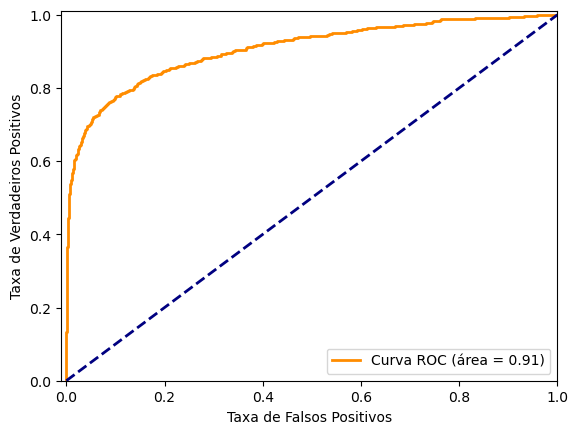

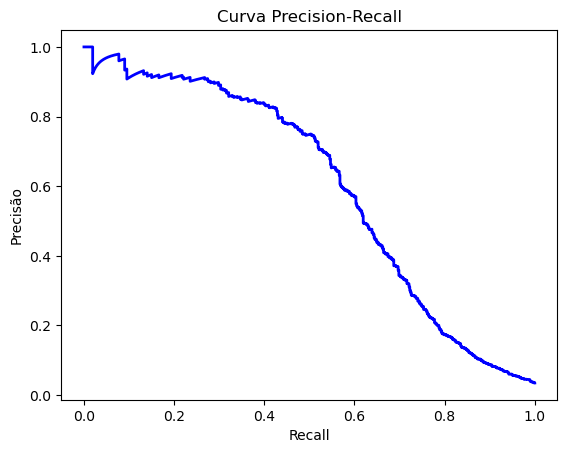

CPU times: user 19min 7s, sys: 14 s, total: 19min 21s
Wall time: 8h 48min 4s


In [23]:
%%time
# Otimizar modelos e encontrar o melhor
best_model, X_test, y_test = optimize_ensemble_models(X_train_res, X_test, y_train_res, y_test)

In [24]:
import joblib

# Salvar o modelo otimizado em disco
model_filename = 'best_xgb_model_10.pkl'
joblib.dump(best_model, model_filename)
print(f"Modelo salvo em: {model_filename}")

Modelo salvo em: best_xgb_model_10.pkl


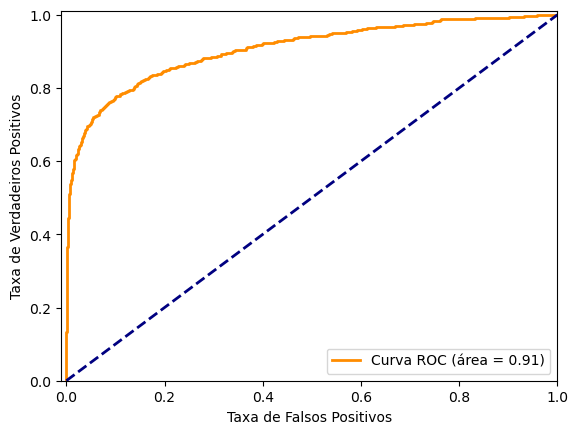

In [25]:
# Gerar e salvar a curva ROC
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Previsões de probabilidade para a classe positiva
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc="lower right")
plt.savefig('images/roc_curve_amostra.png')
plt.show()

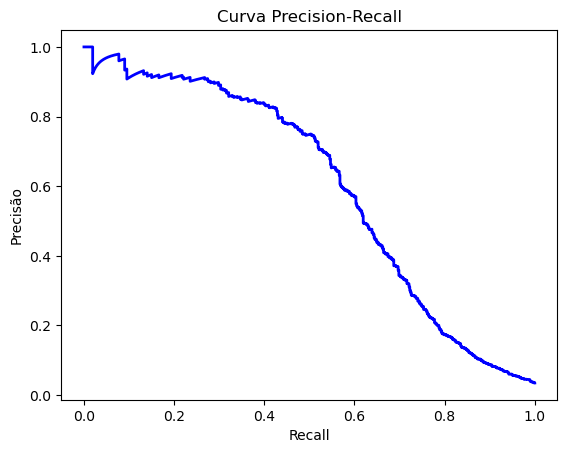

In [26]:
# Gerar e visualizar a curva Precision-Recall
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall_curve, precision_curve, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title(f'Curva Precision-Recall')
plt.savefig('images/precision_recall_amostra.png')
plt.show()

In [27]:
params = best_model.get_params()

# Para imprimir todos os parâmetros
for param, value in params.items():
    print(f"{param}: {value}")

objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: auc
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: 0.011052789103875535
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 17
max_leaves: None
min_child_weight: None
missing: -1
monotone_constraints: None
multi_strategy: None
n_estimators: 1508
n_jobs: None
num_parallel_tree: None
random_state: 42
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: 0.40364340629123596
tree_method: None
validate_parameters: None
verbosity: None
